In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from src.parsers import HMParser, CotevParser
from src.resources import Aggregator, Generator, Load, Storage

from src.algorithms.deterministic import HMMilpPyomo

2024-08-03 21:14:10,069	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

# EC data for non-renewable generators and batteries
data_ec = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data_ec.parse()

# EV data from the EV4EU simulator
data_ev = CotevParser(population_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/population_731.csv',
                      driving_history_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/ev_driving_history_731.csv',
                      assigned_segments_path='/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/assigned_segments_731.csv',
                      parse_date_start='2019',
                      parse_date_end='2020')
data_ev.parse()

In [3]:
# UPAC Data load

data_upacs = {}
for i in glob.glob('/Users/ecgomes/Documents/PhD/UPAC data/upac*_pv.csv'):
    temp = pd.read_csv(i, index_col=0, parse_dates=True)
    temp = temp.resample('H').mean()

    # Need to divide by 1000 to convert from W to kW
    temp['pv'] = temp['pv'] / 1000
    temp['load'] = temp['load'] / 1000

    # Set any negative values to zero
    temp.loc[temp['pv'] < 0, 'pv'] = 0
    temp.loc[temp['load'] < 0, 'load'] = 0

    # We only want 2019 and 2020 data
    temp = temp.loc['2019':'2020']

    # Fill potential NaN values with interpolation
    temp = temp.interpolate()

    name = i.split('/')[-1].split('_')[0].split('upac')[1]

    data_upacs[name] = temp

In [4]:
# Train resource creation

def create_resources(upacs, ec, ev):
    """
    Create the resources for the training environment.
    return a list of resources.
    :param upacs: dict with the UPAC data
    :param ec: dict with the EC data
    :param ev: dict with the EV data
    """

    resources = []
    # Add generators (from pv column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Generator(
            name='ren_generator_' + current_name,
            value=np.zeros(upacs[current_name]['pv'].shape),
            lower_bound=np.zeros(upacs[current_name]['pv'].shape),
            upper_bound=upacs[current_name]['pv'].values,
            cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs[current_name].shape[0]),
            cost_nde=np.tile(ec.generator['cost_nde'][0], (int(upacs[current_name].shape[0] / 24))),
            is_renewable=True))

    '''
    resources.append(Generator(
        name='generator_14',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    
    resources.append(Generator(
        name='generator_15',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    '''

    # Add loads (from load column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Load(
            name='load_' + current_name,
            value=upacs[current_name]['load'],
            lower_bound=np.zeros(upacs[current_name].shape),
            upper_bound=upacs[current_name]['load'].values,
            cost=np.ones(upacs[current_name].shape[0]),
            cost_cut=np.tile(ec.load['cost_cut'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_reduce=np.tile(ec.load['cost_reduce'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_ens=np.tile(ec.load['cost_ens'][0], (int(upacs[current_name].shape[0] / 24)))))

    # Add storage (from the EC data)
    for i in range(ec.storage['p_charge_limit'].shape[0]):
        resources.append(Storage(
            name='storage_{:02d}'.format(i+1),
            value=ec.storage['initial_state'][i] * np.ones(upacs['02'].shape[0]),
            lower_bound=np.ones(upacs['02'].shape[0]) * ec.storage['energy_min_percentage'][i],
            upper_bound=(ec.storage['energy_capacity'][i] * np.ones(upacs['02'].shape[0])),
            cost=np.ones(upacs['02'].shape[0]),
            cost_discharge=np.tile(ec.storage['discharge_price'][i], (int(upacs['02'].shape[0] / 24))),
            cost_charge=np.tile(ec.storage['charge_price'][i], (int(upacs['02'].shape[0] / 24))),
            capacity_max=ec.storage['energy_capacity'][i],
            capacity_min=ec.storage['energy_min_percentage'][i],
            initial_charge=ec.storage['initial_state'][i],
            discharge_efficiency=ec.storage['discharge_efficiency'][i],
            discharge_max=np.tile(ec.storage['p_discharge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            charge_efficiency=ec.storage['charge_efficiency'][i],
            charge_max=np.tile(ec.storage['p_charge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            capital_cost=np.array([0.05250, 0.10500, 0.01575])))

    # Add vehicles (from the EV data)
    for i in np.arange(len(ev)):
        # Append to the list of resources
        resources.append(ev[i])

    # Append Aggregator
    resources.append(Aggregator(
        name='aggregator',
        value=np.zeros(upacs['02'].shape[0]),
        lower_bound=np.zeros(upacs['02'].shape[0]),
        upper_bound=np.tile(ec.peers['import_contracted_p_max'][0, 0], (upacs['02'].shape[0])),
        cost=np.tile(ec.peers['buy_price'][0, 0], (upacs['02'].shape[0])),
        imports=np.zeros(upacs['02'].shape[0]),
        exports=np.zeros(upacs['02'].shape[0]),
        import_cost=np.tile(ec.peers['buy_price'][0], (int(upacs['02'].shape[0] / 24))), # * 100,
        export_cost=np.tile(ec.peers['sell_price'][0], (int(upacs['02'].shape[0] / 24))),
        import_max=np.tile(ec.peers['import_contracted_p_max'][0, 0], (int(upacs['02'].shape[0]))),
        export_max=np.tile(ec.peers['export_contracted_p_max'][0, 0], (int(upacs['02'].shape[0])))))

    return resources

In [5]:
# Create resources for the training environment

def iterate_resources(u, c, e, mode='daily'):

    temp = {}

    # Save first key of upac data
    first_key = list(u.keys())[0]

    if mode == 'daily':

        # Loop to iterate over days in the datasets
        for i in np.unique(u[first_key].index.date):
            # Create the resources for the training environment

            date = i.strftime('%Y-%m-%d')

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    elif mode == 'monthly':

        # Loop to iterate over months in the datasets
        # Need to be careful with different years
        unique_months = np.unique(data_upacs['02'].index.strftime('%Y-%m'))

        for i in unique_months:
            # Create the resources for the training environment
            date = i

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    elif mode == 'yearly':

        # Loop to iterate over years in the datasets
        unique_years = np.unique(data_upacs['02'].index.strftime('%Y'))

        for i in unique_years:
            # Create the resources for the training environment
            date = i

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    return temp

dataset_resources = iterate_resources(u=data_upacs, c=data_ec, e=data_ev, mode='yearly')

In [28]:
# Test the class

test_milp = HMMilpPyomo(resources=dataset_resources['2019-01'])
test_milp.run_model()

# Solve the model
test_milp.solve_model(write_path='test_milp', solver_path='/usr/local/bin/scip')
milp_results = test_milp.extract_all()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: 457112.406186579
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 61008
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: optimal solution found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 5.96
  Gap: 0.0
  Primal bound: 457112.406186579
  Dual bound: 457112.406186579
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number

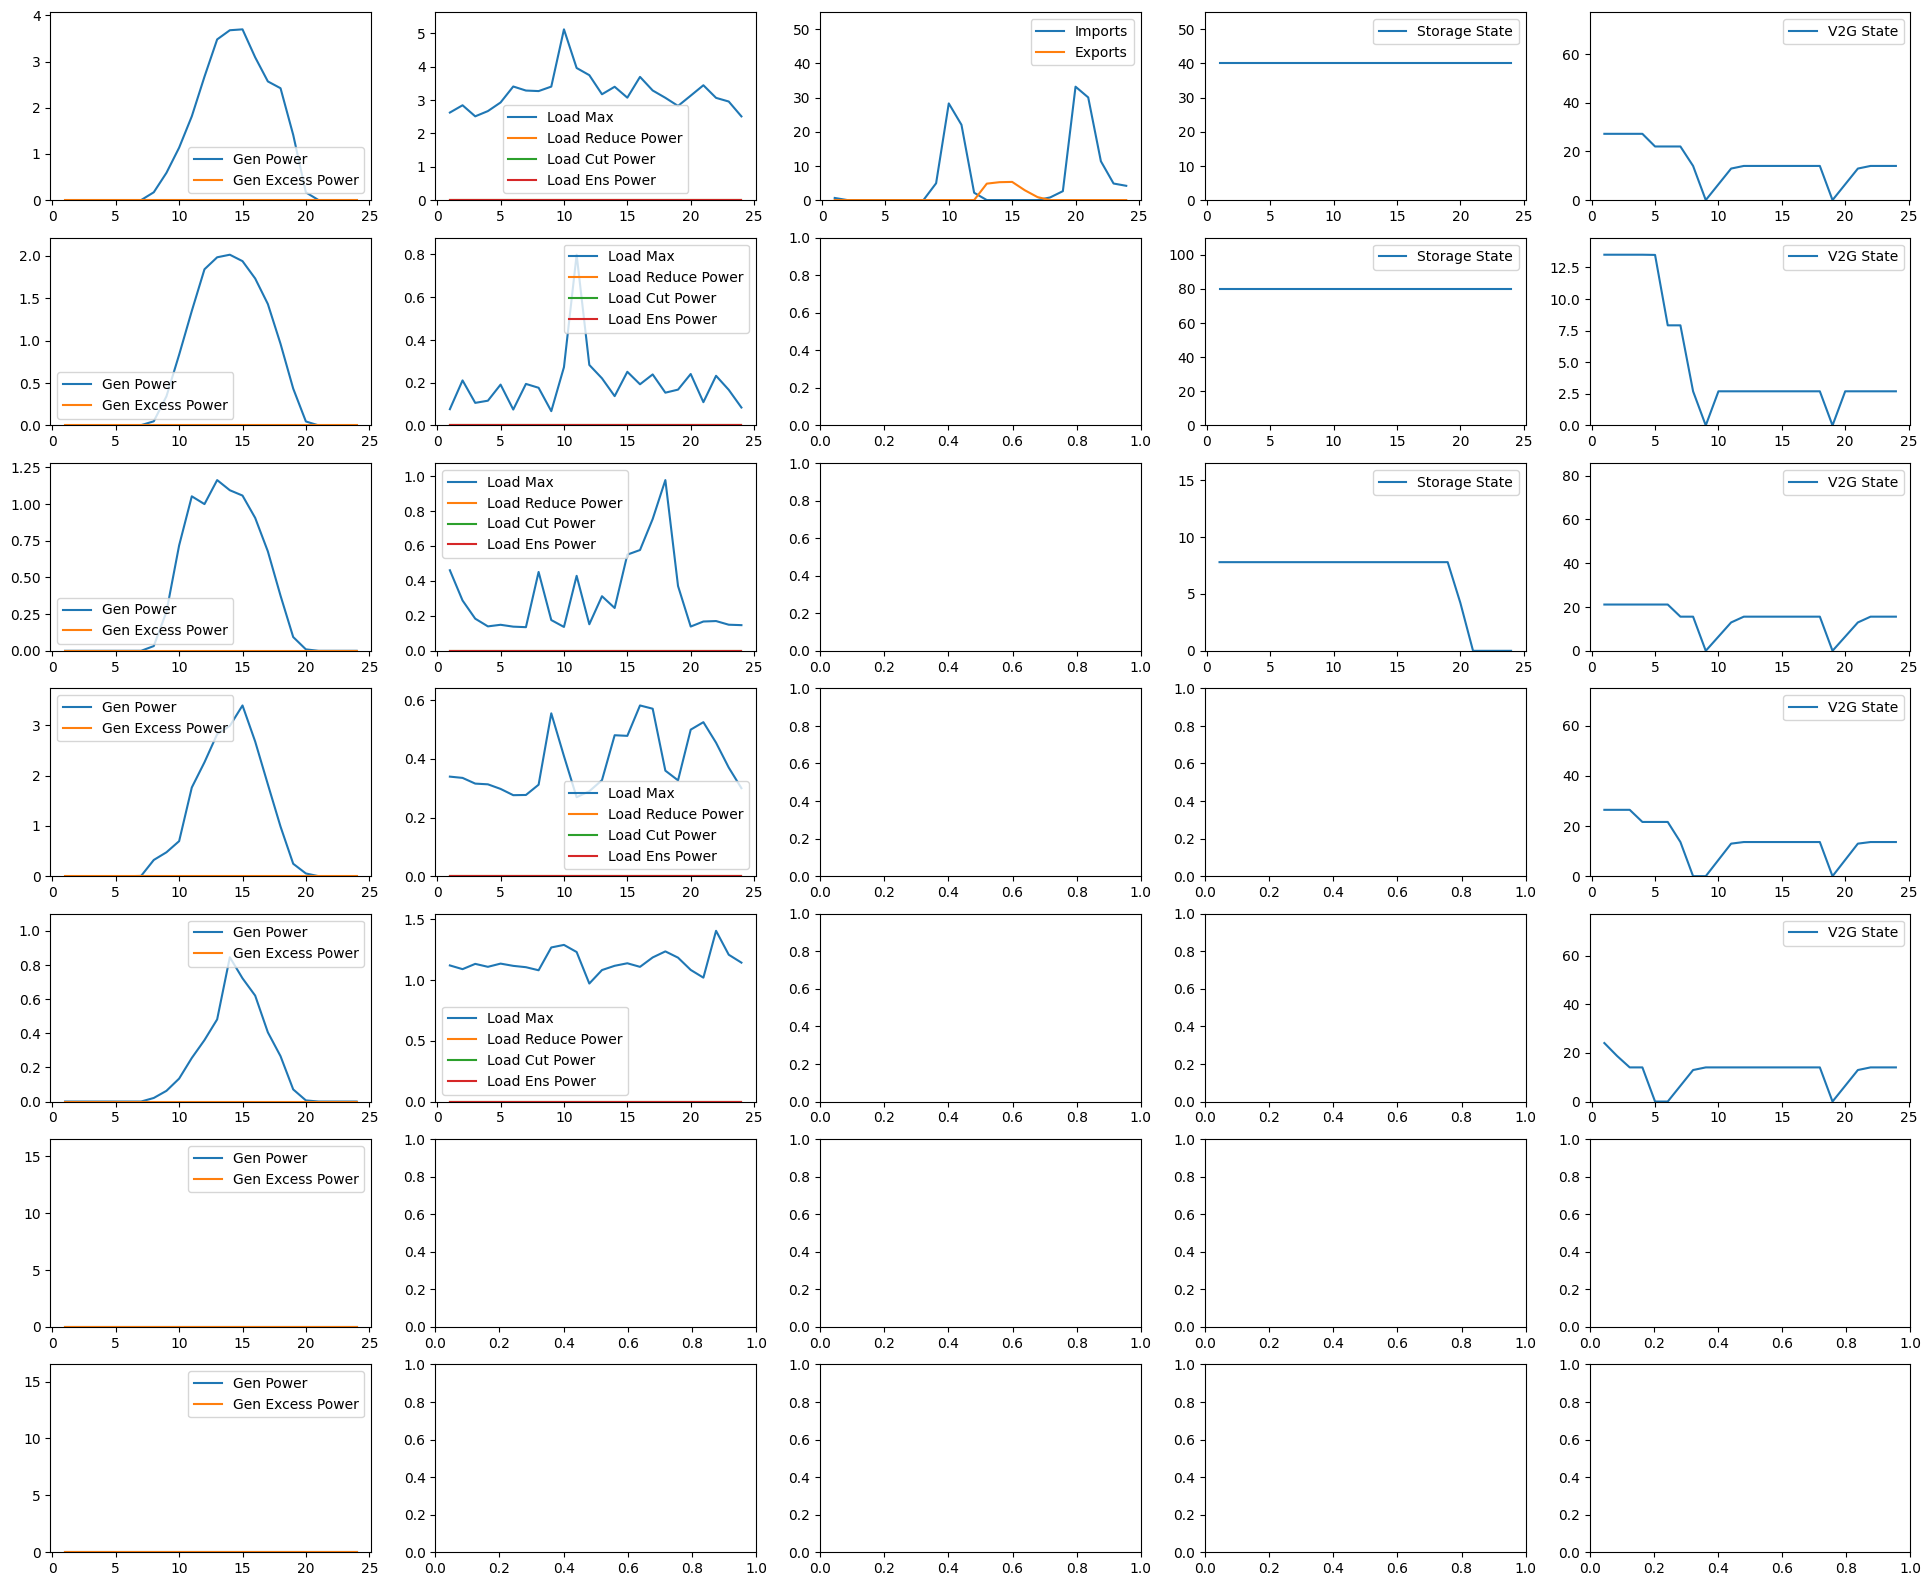

In [7]:
# Plot the MILP results

fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(24, 20))

for i in np.arange(milp_results['genPower'].shape[0]):
    #ax[i, 0].plot(test_milp.extract_results(test_milp.model.genMax).iloc[i, :], label='Gen Max')
    ax[i, 0].plot(milp_results['genPower'].iloc[i, :], label='Gen Power')
    ax[i, 0].plot(milp_results['genExcessPower'].iloc[i, :], label='Gen Excess Power')
    
    if test_milp.extract_results(test_milp.model.genMax).iloc[i, :].max() > 1:
        ax[i, 0].set_ylim([0, 1.1 * test_milp.extract_results(test_milp.model.genMax).iloc[i, :].max()])
    else:
        ax[i, 0].set_ylim(0, 1.1)
    ax[i, 0].legend()
    
for i in np.arange(test_milp.extract_results(test_milp.model.loadMax).shape[0]):
    ax[i, 1].plot(test_milp.extract_results(test_milp.model.loadMax).iloc[i, :], label='Load Max')
    ax[i, 1].plot(milp_results['loadReducePower'].iloc[i, :], label='Load Reduce Power')
    ax[i, 1].plot(milp_results['loadCutPower'].iloc[i, :], label='Load Cut Power')
    ax[i, 1].plot(milp_results['loadEnsPower'].iloc[i, :], label='Load Ens Power')
    ax[i, 1].set_ylim([0, 1.1 * test_milp.extract_results(test_milp.model.loadMax).iloc[i, :].max()])
    ax[i, 1].legend()
    
ax[0, 2].plot(milp_results['imports'], label='Imports')
ax[0, 2].plot(milp_results['exports'], label='Exports')
ax[0, 2].set_ylim([0, 1.1 * test_milp.extract_results(test_milp.model.impMax).iloc[1, :].max()])
ax[0, 2].legend()
    
for i in np.arange(milp_results['storageState'].shape[0]):
    ax[i, 3].plot(milp_results['storageState'].iloc[i, :], label='Storage State')
    ax[i, 3].set_ylim([0, 1.1 * test_milp.extract_results(test_milp.model.storageCapacityMax).iloc[i, :].max()])
    ax[i, 3].legend()
    
for i in np.arange(milp_results['v2gState'].shape[0]):
    ax[i, 4].plot(milp_results['v2gState'].iloc[i, :], label='V2G State')
    ax[i, 4].set_ylim([0, 1.1 * test_milp.extract_results(test_milp.model.v2gCapacityMax).iloc[i, :].max()])
    ax[i, 4].legend()

In [6]:
# Create a loop that iterates over the entries of the dataset_resources dictionary

results = {}

for i in dataset_resources.keys():
    print(i)
    # Create the MILP model
    milp = HMMilpPyomo(resources=dataset_resources[i])
    milp.run_model()

    # Solve the model
    milp.solve_model(write_path='milp', solver_path='/usr/local/bin/scip')
    milp_results = milp.extract_all()

    results[i] = milp_results

2019
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: 5382083.88643537
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 718319
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: optimal solution found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 439.78
  Gap: 0.0
  Primal bound: 5382083.88643537
  Dual bound: 5382083.88643537
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 


In [7]:
# Save the results

import pickle
import os

# Make results directory on the folder
if not os.path.exists('results'):
    os.makedirs('results')

with open('results/results_nogen_yearly.pkl', 'wb') as f:
    pickle.dump(results, f)
    
# Load the results